# Build Predictive Model For Post Tags Classification.

## 1. Overview of the Data

- Post data collected from Stack Overflow is analyzed and normalized ([Post-Categorization
/ConverHtmlToText.py](https://github.com/programmerHoangBao/Post-Categorization.git)) to support building a model that predicts which tags a post belongs to based on its content.
- Data Structure:
  - **Body**: The content of the post is of string data type.
  - **Tags**: The list of tags for the post is of data type 'list'.

## 2. Import libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import make_pipeline
import time
import ast
from collections import Counter
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### 📚 Library Descriptions

| **Library / Module** | **Description** |
|------------------------|-----------------|
| **pandas** | Used for processing and analyzing tabular data (DataFrame), with support for reading and writing CSV files. |
| **sklearn.model_selection.train_test_split** | Splits the dataset into training and test sets to evaluate model performance. |
| **sklearn.feature_extraction.text.TfidfVectorizer** | Converts text data into numerical feature vectors using the TF-IDF (Term Frequency–Inverse Document Frequency) method. |
| **sklearn.preprocessing.MultiLabelBinarizer** | Converts lists of labels into binary matrices for multi-label classification tasks. |
| **sklearn.linear_model.LogisticRegression** | Implements the Logistic Regression algorithm for classification problems. |
| **sklearn.svm.LinearSVC** | Implements a linear Support Vector Machine (SVM) model for classification tasks. |
| **sklearn.naive_bayes.MultinomialNB** | A Naive Bayes classifier suitable for discrete data such as word counts or TF-IDF features. |
| **sklearn.naive_bayes.ComplementNB** | A variant of Naive Bayes that performs better on imbalanced datasets, especially for text classification. |
| **sklearn.multiclass.OneVsRestClassifier** | Implements the One-vs-Rest strategy, training one classifier per class for multi-label or multi-class problems. |
| **sklearn.calibration.CalibratedClassifierCV** | Calibrates classifier probability outputs to make them more reliable, often used with models like SVM that don't output well-calibrated probabilities by default. |
| **sklearn.metrics.f1_score** | Computes the F1-score, which balances precision and recall, to evaluate model accuracy. |
| **sklearn.metrics.classification_report** | Generates a detailed report including precision, recall, F1-score, and support for each label. |
| **sklearn.pipeline.make_pipeline** | Creates a pipeline that chains preprocessing steps and model training into a single workflow. |
| **time** | Standard Python library used to measure execution time and performance. |
| **ast** | Parses strings containing Python expressions into abstract syntax trees, allowing structured manipulation or safe evaluation of text data. |
| **collections.Counter** | Counts the frequency of elements in a list, tuple, or string efficiently. |
| **itertools.chain** | Combines multiple iterables (lists, tuples, etc.) into a single continuous sequence. |
| **numpy** | Supports high-performance numerical computations and operations on arrays and matrices. |
| **matplotlib.pyplot** | Used to create visualizations and charts for data analysis. |
| **seaborn** | A data visualization library built on Matplotlib, providing high-level, attractive, and informative statistical graphics. |
| **joblib** | Provides fast and efficient saving and loading of Python objects, especially useful for large machine learning models. |

## 3. Load data

- The path to the file post.csv—if you don't have it, you can download it from this Drive link: [dataset](https://drive.google.com/file/d/1kUms7-CSwlSG6hEcTz27samjMz6Z0YSp/view?usp=drive_link)

In [3]:
input_path = "/kaggle/input/post-tag-classfication/dataset/post.csv"

In [4]:
df_post = pd.read_csv(input_path)

In [5]:
print(df_post.dtypes)
print(f"Number rows: {len(df_post)}")
print(df_post.head(5))

Body    object
Tags    object
dtype: object
Number rows: 204591
                                                Body  \
0  I have a wcf application hosted in a windows s...   
1  I use Delphi for many years, and although I ha...   
2  I have a\nweb-service\n that I will be deployi...   
3  What are the ways that you use to model and re...   
4  Which class design is better and why?\n\npubli...   

                                Tags  
0                ['wcf', 'security']  
1        ['visual-studio', 'delphi']  
2  ['c#', 'asp.net', 'web-services']  
3    ['sql', 'sql-server', 'oracle']  
4                            ['oop']  


In [6]:
print(df_post["Tags"].apply(type).value_counts())

Tags
<class 'str'>    204591
Name: count, dtype: int64


- As you can see, the 'Tags' column is currently of type 'str', so it needs to be converted to a 'list'.

In [7]:
def normalize_tags(tags):
    if pd.isna(tags):
        return []
    if isinstance(tags, str):
        try:
            return ast.literal_eval(tags)
        except (ValueError, SyntaxError):
            return []
    if isinstance(tags, list):
        return tags
    return []

In [8]:
df_post["Tags"] = df_post["Tags"].apply(normalize_tags)

In [9]:
print(df_post["Tags"].apply(type).value_counts())

Tags
<class 'list'>    204591
Name: count, dtype: int64


In [10]:
tag_counter = Counter(chain.from_iterable(df_post["Tags"]))
tag_counts = pd.Series(tag_counter).sort_values(ascending=False)

In [11]:
print("Number of subject: ", len(tag_counts))
print("Top 10 tags:", tag_counts.head(10).to_dict())
print("Bottom 10 tags:", tag_counts.tail(10).to_dict())

Number of subject:  67
Top 10 tags: {'c#': 34409, '.net': 20357, 'java': 17588, 'asp.net': 15644, 'javascript': 12816, 'php': 11955, 'c++': 11926, 'python': 8972, 'sql': 8391, 'jquery': 7943}
Bottom 10 tags: {'eclipse': 1816, 'macos': 1810, 'silverlight': 1794, 'actionscript-3': 1708, 't-sql': 1675, 'language-agnostic': 1627, 'excel': 1606, 'internet-explorer': 1521, 'nhibernate': 1510, 'exception': 1508}


### 3.1 Frequency distribution of tags

/tmp/ipykernel_10/1464479119.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="coolwarm")


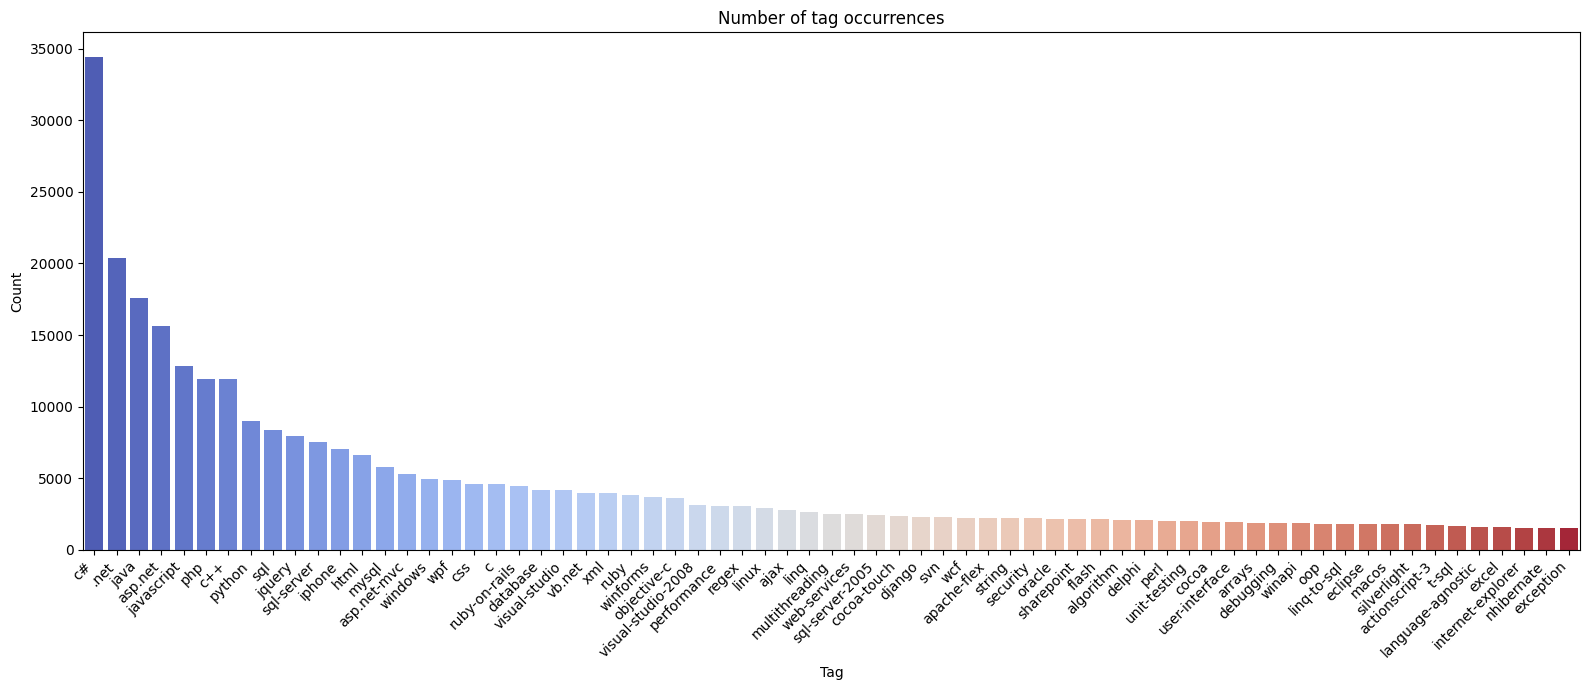

In [12]:
plt.figure(figsize=(16, 7))
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette="coolwarm")
plt.title("Number of tag occurrences")
plt.ylabel("Count")
plt.xlabel("Tag")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Looking at the chart, we can see that **'C#'** has the highest frequency (over 30,000 occurrences), while tags from **'exception'** onward appear fewer than 1600 times. This indicates that the data is imbalanced, which could potentially lead to overfitting.

### 3.2 Average number of tags per post

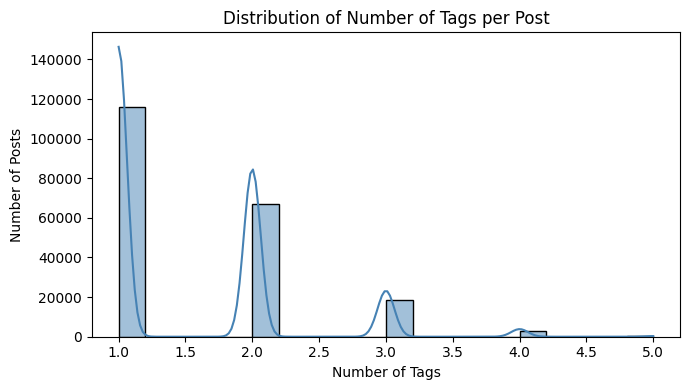

In [13]:
tag_per_post = df_post["Tags"].apply(len)
plt.figure(figsize=(7, 4))
sns.histplot(tag_per_post, bins=20, kde=True, color="steelblue")
plt.title("Distribution of Number of Tags per Post")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

- Helps identify that most posts have 1–4 tags (light multi-label), which supports choosing a prediction threshold/OneVsRest.

### 3.3 Post content length (word count)

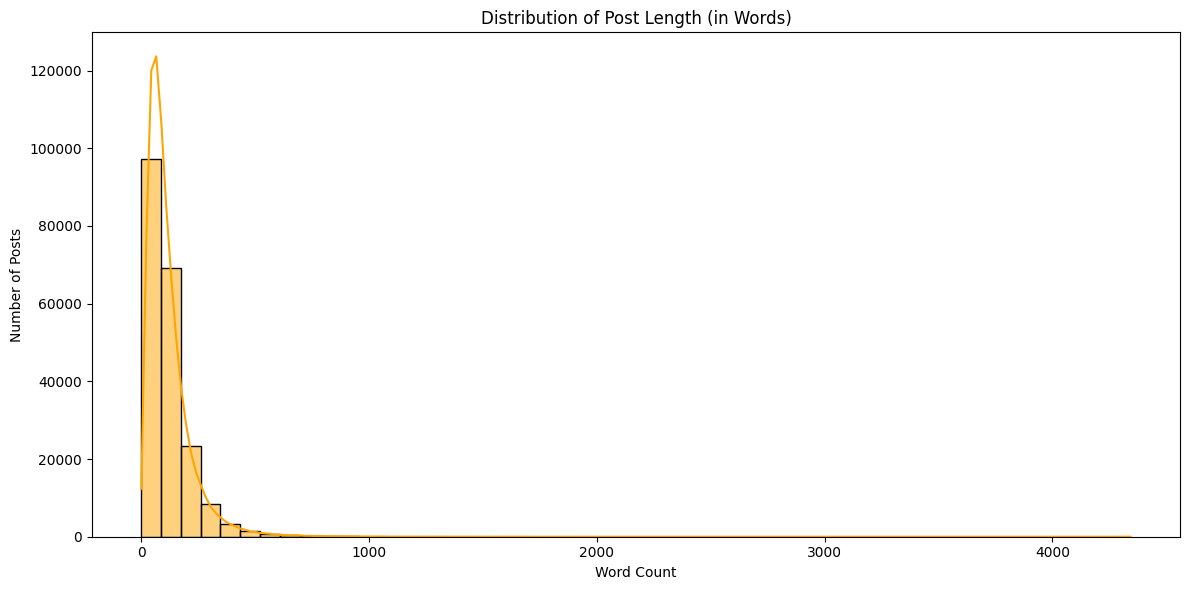

In [14]:
df_post["Body_length"] = df_post["Body"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(df_post["Body_length"], bins=50, kde=True, color="orange")
plt.title("Distribution of Post Length (in Words)")
plt.xlabel("Word Count")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.show()

In [15]:
tokenized_posts = df_post['Body'].dropna().apply(lambda x: str(x).lower().split())

word_in_posts = Counter()
for words in tokenized_posts:
    for word in set(words):
        word_in_posts[word] += 1

num_posts = len(tokenized_posts)

filtered_words = {
    w for w in word_in_posts
    if word_in_posts[w] > 3
    and (word_in_posts[w] / num_posts) < 0.15
}

print(f"🔍 Number of unique meaningful words: {len(filtered_words):,}")
print(f"📝 On average, each post contains {df_post['Body_length'].mean():.0f} words.")

print("\n🔠 Example meaningful words:", list(filtered_words)[:20])

🔍 Number of unique meaningful words: 112,856
📝 On average, each post contains 119 words.

🔠 Example meaningful words: ['<datatemplate.resources>', '2005/2008', 'she', 'sales', '.phony:', '(selected', 'cmd)', 'is",', 'prefix:', "parent's", 'changes', 'trick:', 'intricacies', "'foo':", 'node...', '.netcf', 'compromised', 'test.c:', 'dll"', 'longint;']


### 3.4 Model selection

- The data becomes sparse when vectorized using TF-IDF, so linear models tend to perform well.
- When we transform the data into TF-IDF vectors, algorithms such as Logistic Regression, Linear SVM, and Multinomial Naive Bayes can be applied.

#### Model Selection for the Tag Prediction Task

Based on the provided dataset, we are dealing with a **text classification** problem with the following characteristics:
* **Large number of samples:** 204,591 posts.  
* **High number of classes/labels:** 67 tags.  
* **Light multi-label nature:** Most posts have between 1 and 4 tags.  
* **Average post length:** 119 words.  

The goal is to predict the **set of relevant tags** for a new post.  
Given these characteristics, we adopt the **Binary Relevance** approach — building **67 independent binary classifiers** (one per tag) — and focus on **linear models** that are efficient and scalable.

---

###### Proposed Models

We selected the following models for their balance between **performance**, **training speed**, and **scalability** on large, sparse text datasets.

###### 1. Logistic Regression

* **Nature:** A classic **linear model** for binary classification.  
* **Reasons for selection:**
    * **Performs well on sparse data:** Works efficiently with sparse representations such as TF-IDF or Bag-of-Words.  
    * **Fast and scalable:** Trains quickly even with high-dimensional data.  
    * **Interpretability:** Model coefficients are easy to interpret — helping identify which words most influence tag prediction.  
    * **Excellent for light multi-label tasks:** A top choice for Binary Relevance setups due to its strong linear performance.

---

###### 2. Linear Support Vector Machine (Linear SVM)

* **Nature:** A powerful linear model that finds the optimal hyperplane maximizing the margin between classes.  
* **Reasons for selection:**
    * **Optimal separation capability:** Excels at finding robust decision boundaries in high-dimensional feature spaces.  
    * **Performs well with sparse data:** Efficiently handles sparse feature matrices.  
    * **Strong performance:** Often matches or surpasses Logistic Regression in text classification tasks.  
    * **Speed considerations:** Using algorithms like SGD or LinearSVC enables fast and scalable training.

---

###### 3. Multinomial Naive Bayes (MNB)

* **Nature:** A probabilistic model based on Bayes’ theorem, best suited for count-based features.  
* **Reasons for selection:**
    * **Extremely fast training:** One of the **fastest** algorithms to train, providing a strong performance baseline.  
    * **Text classification suitability:** Specifically designed for handling word frequency features (e.g., Bag-of-Words).  
    * **Surprisingly effective:** Despite its “naive” independence assumption, it often performs very well in real-world applications.

---

###### Conclusion and Implementation Approach

We will train **67 binary classifiers** for each of the above models, following the **Binary Relevance** approach.

| **Model** | **Key Advantages** | **Best Use Case** |
|:-----------|:------------------|:------------------|
| **Logistic Regression** | High performance, interpretable, fast training | Balanced choice between performance and speed. |
| **Linear SVM** | Optimal classification boundary, competitive performance | For achieving the highest possible accuracy. |
| **Multinomial Naive Bayes** | Extremely fast training, strong baseline | Ideal for quick and reliable baseline models. |

By using all three models, we ensure that we have both a **strong baseline (Multinomial Naive Bayes)** and two **robust linear models (Logistic Regression and Linear SVM)** optimized for large-scale, sparse text data.


## 4. Prepare training data

- **features (X)**: This is the textual content of the post (the 'Body' column). It serves as the input data from which the model learns to predict labels.
- **labels (y)**: This is a list of tags (topic labels) associated with each post. Since a post can have multiple tags, this is a multi-label classification problem.

In [16]:
X = df_post["Body"]
y = df_post["Tags"]

- **Multi-label encoder**: Convert the lists of tags into a binary matrix (0–1 format).
- **Fit the encoder and apply data transformation**: Learn all the tags present in the data and encode each post accordingly.

In [17]:
mlb = MultiLabelBinarizer()
y_bin = mlb.fit_transform(y)

In [18]:
print(mlb.classes_[:10])
print(y_bin.shape)

['.net' 'actionscript-3' 'ajax' 'algorithm' 'apache-flex' 'arrays'
 'asp.net' 'asp.net-mvc' 'c' 'c#']
(204591, 67)


- Split the dataset into two parts: a training set and a test set.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=42
)

## 5. Define the training and evaluation functions.

- Comprehensive evaluation function — automatically trains the model, measures training time, makes predictions, and computes the F1 score for the classification model.
- **Process Overview**:
  - **Step 1: Display Model Name**
    - Prints a header showing which model is currently being evaluated.
  - **Step 2: Train the Model**
    - Starts a timer to measure how long the training process takes.
    - Fits the model using the provided training data (X_train, y_train).
    - Calculates the total training time in seconds.
  - **Step 3: Make Predictions**
    - Uses the trained model to predict labels for the test dataset (X_test).
    - The predicted values are stored in y_pred.
  - **Step 4: Evaluate Model Performance**
    - Computes two types of F1 scores:
      - **F1-micro**: Evaluates performance globally by counting the total true positives, false negatives, and false positives.
      - **F1-macro**: Evaluates performance by computing the mean F1 score for each class, giving equal weight to all classes.
  - **Step 5: Display Results**
    - Total training time (in seconds)
    - F1-micro score
    - F1-macro score
  - **Step 6: Return Results**
    - Returns a dictionary containing:
    ```json
        {
            "model": "Logistic Regression",
            "micro": 0.753,
            "macro": 0.725,
            "time": 12.34
        }

In [20]:
def evaluate_model(model, model_name):
    print(f"\n===== {model_name} =====")
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    # Prediction
    y_pred = model.predict(X_test)

    # If the model doesn't support probabilities → the output will be labels (OK)
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_macro = f1_score(y_test, y_pred, average="macro")

    print(f"Training time: {train_time:.2f}s")
    print(f"F1-micro: {f1_micro:.4f}")
    print(f"F1-macro: {f1_macro:.4f}")
    
    return {"model": model_name, "micro": f1_micro, "macro": f1_macro, "time": train_time}

## 6. Initialize the vectorizer

- Transform text into numerical vectors — specifically TF-IDF vectors — for training machine learning models.
- **_Note_**:
  - Limit to the top 50,000 features (most frequent words/terms) to avoid memory overload and data noise.
  - Use both unigrams (single words) and bigrams (two consecutive words).
    - Example: 'machine learning' → ['machine', 'learning', 'machine learning']
  - Remove English stop words (such as “a”, “the”, “is”, “and”) as they often carry little meaningful information.

In [21]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=4,
    max_df=0.85,
    stop_words="english"
)

## 7. Define the model

- **LogisticRegression**: Logistic regression model, commonly used for binary or multi-class classification.
- **LinearSVC**: Linear SVM model, highly effective for text classification tasks.
- **MultinomialNB**: The Naive Bayes model based on the multinomial distribution is widely used in text classification due to its efficiency and high speed.
- **OneVsRestClassifier**: Since the original SVM only supports binary classification, it needs to be wrapped to handle multiple labels simultaneously.

In [22]:
models = [
    ("Logistic Regression",
     make_pipeline(
         tfidf,
         OneVsRestClassifier(
             LogisticRegression(
                 class_weight="balanced",
                 C=3,
                 max_iter=10000,
                 n_jobs=-1
             )
         )
     )),

    ("Linear SVM",
     make_pipeline(
         tfidf,
         OneVsRestClassifier(
             CalibratedClassifierCV(
                 estimator=LinearSVC(
                     class_weight="balanced",
                     max_iter=10000
                 ),
                 method="sigmoid",  # Platt scaling
                 cv=3
             ),
             n_jobs=-1
         )
     )),

    ("Multinomial NB",
     make_pipeline(
         tfidf,
         OneVsRestClassifier(
             ComplementNB(alpha=0.5)
         )
     ))
]

## 8. Training and Evaluation

In [23]:
results = []
for name, model in models:
    results.append(evaluate_model(model, name))


===== Logistic Regression =====
Training time: 237.62s
F1-micro: 0.6059
F1-macro: 0.5999

===== Linear SVM =====
Training time: 51.55s
F1-micro: 0.5916
F1-macro: 0.5571

===== Multinomial NB =====
Training time: 27.43s
F1-micro: 0.3833
F1-macro: 0.2171


## 9. Model Comparison

In [24]:
results_df = pd.DataFrame(results)
best_model = results_df.sort_values(by="micro", ascending=False).iloc[0]

- Visualize Model Comparison

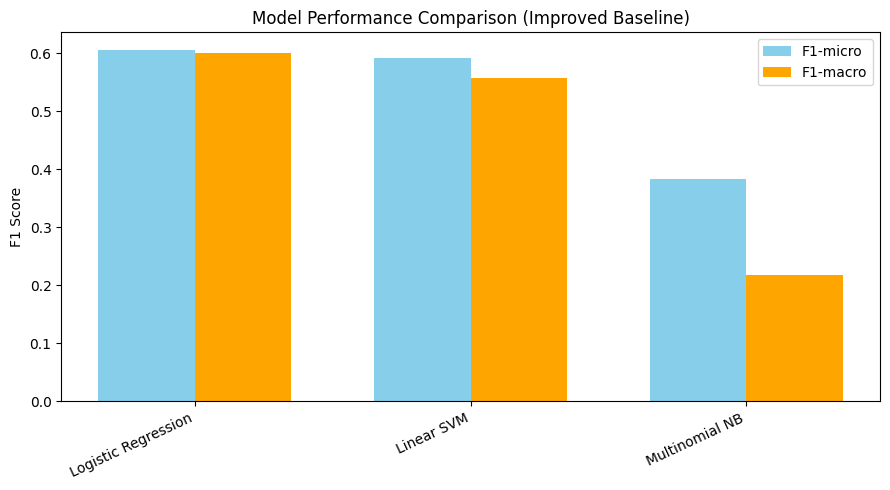

In [25]:
plt.figure(figsize=(9, 5))
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df["micro"], width, label="F1-micro", color="skyblue")
plt.bar(x + width/2, results_df["macro"], width, label="F1-macro", color="orange")

plt.xticks(x, results_df["model"], rotation=25, ha="right")
plt.ylabel("F1 Score")
plt.title("Model Performance Comparison (Improved Baseline)")
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
print("\n=== 📊 Summary of Results ===")
print(results_df)
print("\n🏆 Best Model:")
print(best_model)


=== 📊 Summary of Results ===
                 model     micro     macro        time
0  Logistic Regression  0.605852  0.599921  237.618711
1           Linear SVM  0.591602  0.557089   51.550107
2       Multinomial NB  0.383285  0.217069   27.432801

🏆 Best Model:
model    Logistic Regression
micro               0.605852
macro               0.599921
time              237.618711
Name: 0, dtype: object


## 11. Export the model

In [27]:
best_model_name = best_model["model"]

best_model_obj = None
for name, model in models:
    if name == best_model_name:
        best_model_obj = model
        break

print(f"\n🚀 Re-training best model on full training set: {best_model_name}")
best_model_obj.fit(X_train, y_train)

save_path = f"best_model_{best_model_name.replace(' ', '_')}.joblib"
joblib.dump(best_model_obj, save_path)
print(f"✅ Best model saved to: {save_path}")

joblib.dump(mlb, "label_binarizer.joblib")
print("✅ Label binarizer saved.")


🚀 Re-training best model on full training set: Logistic Regression
✅ Best model saved to: best_model_Logistic_Regression.joblib
✅ Label binarizer saved.


In [29]:
model = joblib.load("/kaggle/working/best_model_Logistic_Regression.joblib")
mlb = joblib.load("/kaggle/working/label_binarizer.joblib")

def predict_tags(text):
    pred = model.predict([text])
    tags = mlb.inverse_transform(pred)
    return tags[0] if tags else []

sample_text = "How can I fix a NullPointerException in Java when using HashMap?"
print("Predicted Tags:", predict_tags(sample_text))

Predicted Tags: ('java',)


## 12. Find the optimal confidence threshold for the model.

- To optimize model performance, we need to determine the confidence threshold of the predictions and only accept results within this threshold.

### 12.1 Overview of the idea

#### Strategy for Finding the Optimal Prediction Threshold

In multi-label classification, many models (such as Logistic Regression or SVM with probability calibration) output **probability scores** instead of direct binary labels (0 or 1).  
To convert these probabilities into final tag predictions, we must choose a **decision threshold** `t`, where:

> If `P(tag | post) > t`, then the tag is considered predicted for that post.

By default, `t = 0.5` is commonly used, but this may not yield the best balance between **precision** and **recall** for all datasets — especially in **imbalanced multi-label tasks**.

---

#### Optimization Approach

We systematically test multiple threshold values in the range `[0, 1]` to find the one that **maximizes the F1-score**, which measures the balance between precision and recall.


- Obtain predicted probabilities for the test set using:

In [30]:
proba_scores = model.predict_proba(X_test)

- Define a set of candidate thresholds (e.g., 30 evenly spaced values between 0 and 1)
- For each threshold t:
  - Convert probabilities to binary predictions:
    <code>y_pred = (proba_scores > t).astype(int)<code>
  - Compute F1-micro and F1-macro scores to evaluate performance:

In [31]:
thresholds = np.linspace(0, 1, 30)  # vì xác suất nằm trong [0,1]
f1_micro_scores, f1_macro_scores = [], []

for t in thresholds:
    y_pred_thresh = (proba_scores > t).astype(int)
    f1_micro_scores.append(f1_score(y_test, y_pred_thresh, average="micro"))
    f1_macro_scores.append(f1_score(y_test, y_pred_thresh, average="macro"))

- Select the threshold that yields the highest F1-micro score:

In [32]:
best_idx = np.argmax(f1_micro_scores)
best_threshold = thresholds[best_idx]

print(f"🔥 Optimal Threshold: {best_threshold:.3f}")
print(f"F1-micro: {f1_micro_scores[best_idx]:.4f}")
print(f"F1-macro: {f1_macro_scores[best_idx]:.4f}")

🔥 Optimal Threshold: 0.724
F1-micro: 0.6269
F1-macro: 0.6196


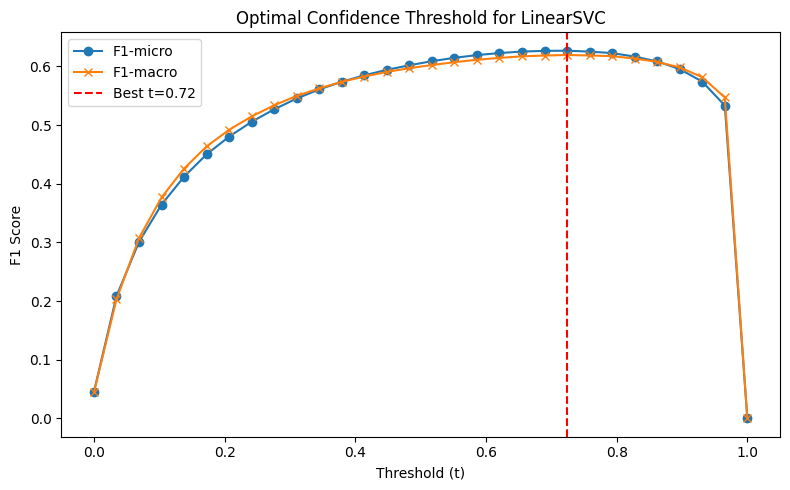

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_micro_scores, label="F1-micro", marker='o')
plt.plot(thresholds, f1_macro_scores, label="F1-macro", marker='x')
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best t={best_threshold:.2f}")
plt.xlabel("Threshold (t)")
plt.ylabel("F1 Score")
plt.title("Optimal Confidence Threshold for LinearSVC")
plt.legend()
plt.tight_layout()
plt.show()

- Review the model with Optimal Threshold

In [34]:
def predict_tags_with_score(text, threshold=0.0):
    confidence_scores = model.predict_proba([text])[0]
    y_pred = (confidence_scores >= threshold).astype(int)
    tags = mlb.inverse_transform(np.array([y_pred]))[0] if np.any(y_pred) else []
    tag_scores = {tag: float(confidence_scores[i]) for i, tag in enumerate(mlb.classes_)}
    selected_scores = {tag: tag_scores[tag] for tag in tags}
    return {
        "tags": list(tags),
        "scores": selected_scores
    }

In [35]:
sample_text = "Cooking is both an art and a science — the right ingredients and timing make all the difference."
scores = model.predict_proba([sample_text])[0]

if np.max(scores) < best_threshold:
    print("Predicted label: unknown")
else:
    print("Predicted Tags:", predict_tags_with_score(sample_text, best_threshold))

Predicted label: unknown
